## Overview
### This notebook is designed to finalize the ICU stays for which CDI risk will be predicted, and label these patients with included cases of CDI. 
##### Key exclusion criteria:
    Patients under age 1 - limited risk of infectious CDI and frequent diarrhea due to other causes
    Patients with pre-existing CDI or strong suspicion prior to ICU stay (eg. diarrhea upon admission)
    Patients without an icustay 
##### Patient Population Description:
    Predictions will be made for each unique ICU stay, and with information gathered anytime prior to 2 days after ICU admission.
    
    Utilizing a standard cutoff of 2 days post-ICU admission aligns with timing of other risk assessments typically made such as mortality/morbidity predictions with scales like APACHE (made around 1 days after ICU admit). As such, a tool based on this model could be implemented into existing clinical workflows.
    

## Notebook sections
   #### a) Import Libraries and Key Data Import; BigQuery OAuth Setup
    Includes import of both patient admits and ICU stays dataframes from first notebook
   #### b) Define functions for use inside notenook
    Date_diff - calculates difference in time between two dates
   #### c) Label Patients With Clostridium difficile infection (CDI)
    1) ID patients noted as having clostridium difficile infection (CDI) at any point during a hospital stay via ICD-9 code
    2) Identify CDI with confirmed diagnosis In Microbiology Events Table
   #### d) Finalize CDI inclusion
    1) Must have timestamped lab diagnosis of CDI after being in the ICU for at least 2 days. This ensures minimal suspsicion or pre-existing CDI diagnosis for patients for whom CDI risk will be predicted
   #### e) Finalize non-CDI admit inclusion
    Largely utilizes features generated in first notebook, and also ensures patients were not discharged from hospital within 2 days after being admitted to ICU
   #### f) Train Test Split
    Ensures all EDA performed on training data throughout rest of notebooks
    
    Key Notes:
    Standard 75%/25% train-test split
    Split preserves entirety of each patient's data on same side of split (many have more than one hospital/ICU stay), 
    and ensures the same rate of CDI across the split.
    
    Resulting dataframes maintain both included and excluded icustays/patients. While individual hospital or ICU stays may be excluded from risk prediction, these stays may belong to patients for whom later stays are included. Given that analysis of prior hospital care will be utilized to predict CDI during current icustays, excluded admissions are not dropped from the dataframe. Instead, excluded stays are labeled appropriately and filtered out when conducting EDA.
    

## Output and Results
#### Updated ICU admissions training and test dataframes (two files) with clearly marked CDI cases and inclusion/exclusion status

#### Summary Stats:
    Overall CDI rate of ~1.42%
    670 out of an initial 1079 lab confirmed CDI cases remain included in final analysis based on criteria above
    Total of 47,000 ICU stays remain included in final analysis 
    

## A) Import libraries and Data and set up BigQuery authorization

In [1]:
from google.cloud import bigquery
from google_auth_oauthlib import flow

client = bigquery.Client()

project = 'mimiciii-249117'

In [2]:
# Import libraries for analysis within notebook
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kurtosis, kurtosistest, skew, skewtest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

In [3]:
launch_browser = True

In [4]:
appflow = flow.InstalledAppFlow.from_client_secrets_file(
    'C:/Users/fuzzyman27/BigQuery/client_secrets.json',
    scopes=['https://www.googleapis.com/auth/bigquery'])

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=579414793473-ak30u31klvdecqfv6kg8542ofeeegm18.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=LnKWQAvwG1rSLwweHxUKAZgaefoaJo&access_type=offline&code_challenge=45EI4jsPOlkEydnK1F-udiELDgBsPw5Y_7IboZfm-PY&code_challenge_method=S256


In [5]:
client = bigquery.Client(project=project, credentials=credentials)

In [6]:
# Define small function to run SQL queries and return a dataframe
def run_query(query):
    return client.query(query).to_dataframe()

#### Import Patient Admits and ICU Stays DataFrames from 1st Notebook

In [12]:
patient_admits = pd.read_csv("../Data/1 - Patient Admits.csv").drop(columns = "Unnamed: 0")
icu_stays = pd.read_csv("../Data/1 - ICU Stays.csv").drop(columns = "Unnamed: 0")

## B) Define function to compare dates

In [7]:
# Define function that returns difference in days of two dates
def date_diff(first_date, second_date):
    diff = (first_date - np.timedelta64(0,'s')) - (second_date - np.timedelta64(0,'s'))
    return ((diff.components.days) + (diff.components.hours/24) + (diff.components.minutes/(60*24)))

## C) Label Patients With Clostridium difficile infection (CDI)

##### Step 1:
##### ID patients noted as having clostridium difficile infection (CDI) at any point during a hospital stay.

Below query selects for CDI via ICD-9 code 00.845

Results in 1,444 unique admissions (~2.4% of all ICU admissions)

In [13]:
query = """
    SELECT SUBJECT_ID as subject_id, HADM_ID as hadm_id, ICD9_CODE as cdi_icd9
    FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
    WHERE ICD9_CODE = '00845'
    ;
"""
cdi_icd9 = run_query(query)

In [14]:
# Merge patient admits df with patients having CDI ICD-9 diagnosis
patient_admits = pd.merge(patient_admits,
                          cdi_icd9[["hadm_id", "cdi_icd9"]],
                          how = "left",
                          on = "hadm_id")

In [15]:
# Modify column to be binary
patient_admits["cdi_icd9"] = patient_admits["cdi_icd9"].fillna(0).map(lambda x: 0 if x == 0 else 1)

#### Step 2: Identify Diagnoses Via Microbiology Events

The microbiology events table is described as housing traditional culture tests, but is known to contain toxin A/B and other diagnostic tests for CDI. Not shown here, but the lab_events table is restricted to blood gas, hematology and chemistries and does not include CDI testing.

In [16]:
# Generate dataframe of all stool microbiology tests
query = """
    SELECT *
    FROM `physionet-data.mimiciii_clinical.microbiologyevents`
    WHERE spec_type_desc LIKE "STOOL%" 
    ;
"""
stool_micro_tests = run_query(query)

In [17]:
stool_micro_tests.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'SPEC_ITEMID', 'SPEC_TYPE_DESC', 'ORG_ITEMID', 'ORG_NAME',
       'ISOLATE_NUM', 'AB_ITEMID', 'AB_NAME', 'DILUTION_TEXT',
       'DILUTION_COMPARISON', 'DILUTION_VALUE', 'INTERPRETATION'],
      dtype='object')

In [18]:
# Organism ID 80139 represents a positive culture result for clostridium difficile
cdi_lab_dx = stool_micro_tests[stool_micro_tests["ORG_ITEMID"] == 80139]["HADM_ID"]
cdi_lab_dx.value_counts()

100517    3
163327    3
181720    3
170640    3
181968    2
         ..
111970    1
111969    1
189030    1
159071    1
198656    1
Name: HADM_ID, Length: 1079, dtype: int64

Around 1079 unique patient admissions were associated with a lab confirmed CDI diagnosis. Several of these patients had more than 1 CDI test during the admission.

Given 1,444 total CDI admissions, there are several hundred patients without a lab-confirmed CDI diagnosis. It's possible that these patients had a clostridium difficile test that returned negative but were still clinically diagnosed and treated for CDI. 

Though it would be beneficial to identify these patients, test results not associated with a specific organism could also be ordered for diagnosing other GI conditions (eg other bacterial, viral, parasitic infection). Further, patients often receive several stool microbiology tests over the course of an admission and it would be difficult to determine which test to rely on as the time when CDI was clinically diagnosed. As such, these patients are excluded from further analysis.

#### Add CDI diagnosis times to patient admits dataframe 

In [19]:
# Count unique chart times of positive CDI tests for each patient admission
cdi_lab_dx_count_charttimes = stool_micro_tests[(stool_micro_tests["ORG_ITEMID"] == 80139) &
                                                (stool_micro_tests["CHARTTIME"].notnull())]
cdi_lab_dx_count_charttimes["HADM_ID"].value_counts()

170640    3
163327    3
181720    3
100517    3
191576    2
         ..
101735    1
138598    1
128362    1
111970    1
198656    1
Name: HADM_ID, Length: 1043, dtype: int64

In [20]:
# Count unique chart dates of positive CDI tests for each patient admission
cdi_lab_dx_count_chartdate = stool_micro_tests[(stool_micro_tests["ORG_ITEMID"] == 80139) &
                                                (stool_micro_tests["CHARTDATE"].notnull())]
cdi_lab_dx_count_chartdate["HADM_ID"].value_counts()

100517    3
163327    3
181720    3
170640    3
181968    2
         ..
111970    1
111969    1
189030    1
159071    1
198656    1
Name: HADM_ID, Length: 1079, dtype: int64

While all positive CDI tests are associated with a chart date, 36 patients are missing a chart time (includes time of day as well as date)

To maintain the added detail of chart time, missing times are filled in with midnight of that day. Setting missing times to the start of the day:

    1) ensures no data gathered after CDI diagnosis is accidentally used in CDI prediction and
    2) maintains the spirit of identifying at risk patients well before lab testing is ordered

In [21]:
# Create list of patients with lab confirmed CDI but missing charttime
missing_charttime_rows = cdi_lab_dx_count_chartdate[cdi_lab_dx_count_chartdate["CHARTTIME"].isnull()]["ROW_ID"].to_list()

# Set charttime = chartdate if missing
for i in cdi_lab_dx_count_chartdate.index:
    chart_date = cdi_lab_dx_count_chartdate.loc[i, "CHARTDATE"]
    if (cdi_lab_dx_count_chartdate.loc[i, "ROW_ID"] in (missing_charttime_rows)):
        cdi_lab_dx_count_chartdate.loc[i, "CHARTTIME"] = chart_date

C:\Users\fuzzyman27\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
# Create unique list of admission ID's for positive CDI tests
cdi_dx_hadm_list = list(set(cdi_lab_dx_count_chartdate["HADM_ID"].to_list()))

In [23]:
# Save for later - order of stool tests
stool_micro_tests[((stool_micro_tests["ORG_ITEMID"].isnull()) | (stool_micro_tests["ORG_ITEMID"] == 80139))
                   & stool_micro_tests["HADM_ID"].isin(cdi_dx_hadm_list)].sort_values(by = ["HADM_ID", "CHARTDATE"])

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
26117,528680,69343,100217,2126-04-01,2126-04-01 15:22:00,70064,STOOL,80139.0,CLOSTRIDIUM DIFFICILE,1.0,NaN,None,None,None,NaN,None
26118,528695,69343,100217,2126-04-05,NaT,70064,STOOL,80139.0,CLOSTRIDIUM DIFFICILE,1.0,NaN,None,None,None,NaN,None
26034,456396,49079,100234,2118-11-02,2118-11-02 12:10:00,70064,STOOL,80139.0,CLOSTRIDIUM DIFFICILE,1.0,NaN,None,None,None,NaN,None
292,8130,652,100262,2142-04-28,2142-04-28 00:45:00,70064,STOOL,NaN,None,NaN,NaN,None,None,None,NaN,None
293,8143,652,100262,2142-05-01,2142-05-01 17:24:00,70064,STOOL,NaN,None,NaN,NaN,None,None,None,NaN,None
294,8160,652,100262,2142-05-05,2142-05-05 06:03:00,70064,STOOL,NaN,None,NaN,NaN,None,None,None,NaN,None
295,8163,652,100262,2142-05-06,2142-05-06 06:30:00,70064,STOOL,NaN,None,NaN,NaN,None,None,None,NaN,None
296,8167,652,100262,2142-05-07,2142-05-07 04:53:00,70064,STOOL,NaN,None,NaN,NaN,None,None,None,NaN,None
301,8212,652,100262,2142-05-27,2142-05-27 04:12:00,70064,STOOL,NaN,None,NaN,NaN,None,None,None,NaN,None
25236,8214,652,100262,2142-05-27,2142-05-27 09:50:00,70064,STOOL,80139.0,CLOSTRIDIUM DIFFICILE,1.0,NaN,None,None,None,NaN,None


In [24]:
# Iterate through admission ID's and identify earliest diagnosis when >1 test was ordered
first_cdi_dx_df = pd.DataFrame()
first_cdi_dx_df["hadm_id"] = cdi_dx_hadm_list
first_cdi_dx_charttime = []
for admit in cdi_dx_hadm_list:
    cdi_test_df = cdi_lab_dx_count_chartdate[cdi_lab_dx_count_chartdate["HADM_ID"] == admit]
    time = cdi_test_df["CHARTTIME"].min()
    first_cdi_dx_charttime.append(time)
first_cdi_dx_df["cdi_dx_charttime"] = first_cdi_dx_charttime

In [25]:
# Add CDI dx times to patient admits df
patient_admits = pd.merge(patient_admits,
                          first_cdi_dx_df,
                          on = "hadm_id",
                          how = "left")

In [26]:
patient_admits["cdi_lab_dx"] = patient_admits["cdi_dx_charttime"].isnull().map(lambda x: 1 if x == False else 0)

In [27]:
icu_stays.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'intime', 'outtime', 'los',
       'icu_stay_seq'],
      dtype='object')

#### Merge Unique ICU Stays With Patient Admissions

Given predictions will be made each time a patient is still in the hospital two days after entering the ICU, unique patient admissions now need to be converted to include all unique ICU stays

In [28]:
patient_admits = pd.merge(patient_admits,
                          icu_stays[["hadm_id",
                                     "intime",
                                     "outtime",
                                     "los",
                                    "icu_stay_seq",
                                    "icustay_id"]].rename(columns = {"intime" : "icu_intime",
                                                               "outtime" : "icu_outtime",
                                                               "los" : "icu_los"}),
         how = "left",
         on = "hadm_id")

##### Convert icu intime and outtime to Timestamp data types

In [29]:
adj_intime = []
adj_outtime = []

for i in patient_admits.index:
    admit_icu_stays = patient_admits.loc[i, "admit_icu_stays"]
    if admit_icu_stays > 0:
        adj_intime.append(pd.Timestamp(patient_admits["icu_intime"][i]))
        adj_outtime.append(pd.Timestamp(patient_admits["icu_outtime"][i]))
    else:
        adj_intime.append(None)
        adj_outtime.append(None)

In [30]:
patient_admits["icu_intime"] = adj_intime
patient_admits["icu_outtime"] = adj_outtime

In [31]:
# Confirm data types
print(patient_admits["icu_intime"].dtypes)
print(patient_admits["icu_outtime"].dtypes)
print(patient_admits["icu_los"].dtypes)

datetime64[ns]
datetime64[ns]
object


In [32]:
# LOS should be a float - print series to evaluate
patient_admits["icu_los"].sort_values()

26999    0 days 16:05:00
13141    0 days 21:30:00
19157             0.0001
28282             0.0002
11286             0.0003
              ...       
62347                NaN
62409                NaN
62562                NaN
62563                NaN
62606                NaN
Name: icu_los, Length: 62722, dtype: object

Some of the LOS calculations were stored in datetime format as opposed to floats. Correction for these below:

In [33]:
print(patient_admits[patient_admits["icu_los"].str.contains("days") == True]["icu_los"])
index_list = patient_admits[patient_admits["icu_los"].str.contains("days") == True]["icu_los"].index.to_list()

657      25 days 10:01:00
6755      9 days 09:14:00
8367      4 days 01:37:00
11333     7 days 09:40:00
13141     0 days 21:30:00
13194    18 days 16:46:00
13333     3 days 17:53:00
19071     5 days 12:54:00
25871     5 days 12:54:00
26999     0 days 16:05:00
Name: icu_los, dtype: object


In [34]:
# For each string that is formatted as a date, split into two components:
# first is the number of days at beginning of string, and second is a list of each component of time (hours, minutes, seconds)
# Then sum up all 4 components converted into a portion of days, and update icu_los values
for i in index_list:
    date = patient_admits.loc[i,"icu_los"]
    length = len(date)
    days = 0
    if length == 16:
        days = float(date[0:2])
        time_components = date[8:].split(":")
    else:
        days = float(date[0:1])
        time_components = date[7:].split(":")
    days = ((days) + 
            (float(time_components[0])/24) +
            (float(time_components[1])/60/24) +
            (float(time_components[2])/60/60/24))
    patient_admits.loc[i,"icu_los"] = days

In [35]:
# Convert whole icu_los column to float
patient_admits["icu_los"] = patient_admits["icu_los"].astype(float)

##### Convert hospital admit and discharge times to timsetamp

In [36]:
admittime = []
for i in patient_admits.index:
    admittime.append(pd.Timestamp(patient_admits["admittime"][i]))

In [37]:
patient_admits["admittime"] = admittime

In [38]:
dischtime = []
for i in patient_admits.index:
    dischtime.append(pd.Timestamp(patient_admits["dischtime"][i]))

In [39]:
patient_admits["dischtime"] = dischtime

## D) Finalize CDI admissions to exclude from analysis

#### 1) Exclude certain CDI patients 


##### a) CDI patients without confirmed lab diagnosis:

As noted above, without a confirmed lab test, timing of diagnosis is difficult to identify and as such, these patients are excluded.

There are also 130 patients with with a confirmed lab test but no CDI ICD9 code listed (13% of positive lab tests). 

There are two main categories of lab testing clinically utilized to diagnose CDI. The first are immunoassays, which can be broken down into to Glutamate Dehydrogenase and Toxin A/B detection. The second are nucleic acid amplification tests (NAATs). 

Immunoassays tend to be more specific but less sensitive than NAATs, and given that Clostridium Difficile can colonize patients without causing infection, NAATs may/often lead to false positives. In the data here, we can not tell which test is used on which patients. However, all data is for patients between 2001 and 2011. Given that Cepheid's GeneXpert (the first FDA approved NAAT) wasn't approved until 2009, the overwhelming majority of tests here were likely done via immunoassay. Reviews of immunoassay testing (as in Menendez 2017 - see Literature Review/Diagnostics folder) suggest that when done in an algorithm, immunoassay testing achieves about 90% PPV. As such, I keep these patients included.

##### b) Patients with CDI noted as admission diagnosis

##### c) Patients with CDI diagnosed before being in ICU for 48 hours

Plenty of patients are admitted to the ICU with either already confirmed or strongly suspected C Diff. Not only is risk prediction in these patients not highly valuable, but prediction of CDI in these patients is likely easier and may distort model performance.

In [40]:
# Calculate difference between CDI diagnosis and ICU admit time
cdi_vs_icu_intime = []
for i in patient_admits.index:
    cdi_charttime = patient_admits.loc[i,"cdi_dx_charttime"]
    icu_intime = patient_admits.loc[i,"icu_intime"]
    try:
        cdi_vs_icu_intime.append(date_diff(cdi_charttime, icu_intime))
    except:
        cdi_vs_icu_intime.append(None)

In [41]:
# Create column for relative CDI dx vs ICU admission
patient_admits["cdi_vs_icu_intime"] = cdi_vs_icu_intime

In [42]:
patient_admits["cdi_vs_icu_intime"].notnull().sum()

1294

there are 1,294 icu visits in which CDI was diagnosed and has a charttime sometime during the overall hospital visit

In [43]:
patient_admits[(patient_admits["cdi_vs_icu_intime"].notnull())
              & (patient_admits["cdi_vs_icu_intime"] > 2)].shape

(670, 44)

670 of these cases were diagnosed at least 2 days after the start of an ICU visit

In [44]:
# Confirm no CDI cases to be excluded were missed
patient_admits[(patient_admits["cdi_vs_icu_intime"] >= 2) &
              ((patient_admits["diarr_at_admit"] == 1) | (patient_admits["cdi_at_admit"] == 1))]

,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,hadm_id,admittime,dischtime,...,age_below_1,cdi_icd9,cdi_dx_charttime,cdi_lab_dx,icu_intime,icu_outtime,icu_los,icu_stay_seq,icustay_id,cdi_vs_icu_intime


##### Plot distribution of CDI Dx timing for patients to be included

In [45]:
# Create function to plot histogram and associated statistics from a series
# Includes mean, standard deviation, middle 50% bounds, and scipy statistical tests for skewness and kurtosis
def plot_one_hist(series = None, color = None, xlabel = "", ylabel = "", title = ""):
    fig, ax = plt.subplots(figsize = (15, 10))
    sns.distplot(series, kde = False, color = color)
    stats = series.describe()
    count = int(stats["count"])
    mean = stats["mean"]
    std = stats["std"]
    mid = stats["50%"]
    lower = stats["25%"]
    upper = stats["75%"]
    plt.title(title + "\n"  + "n = " + str(count), fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)  
    plt.axvline(x = mean, label = "mean " + str(round(mean, 3)), linewidth = 3, color = "green")
    plt.axvline(x = mean + std, label = "+/- 1 std = " + str(round(std, 3)), linewidth = 3, color = "red")
    plt.axvline(x = mean - std, linewidth = 3, color = "red")
    plt.axvline(x = lower, linewidth = 3, label = "middle 50%: \n" + str(round(lower,3)) + " / " + str(round(upper,3)), color = "orange")
    plt.axvline(x = upper, linewidth = 3, color = "orange")
    plt.legend(fontsize = 15)
    print("Kurtosis / test stat / p-value " + 
          str(round(kurtosis(series), 3)) + " / " + 
          str(round(kurtosistest(series)[0], 3)) + " / " + 
          str(kurtosistest(series)[1]))
    print("Skew statistic / p-value: " + 
          str(round(skew(series), 3)) + " / " + 
          str(skewtest(series)[1]))   

In [46]:
print(stats.shapiro(patient_admits[(patient_admits["cdi_vs_icu_intime"].notnull()) 
                             & (patient_admits["cdi_vs_icu_intime"] >= 2)]["cdi_vs_icu_intime"]))

(0.7709900736808777, 1.5744827874800842e-29)


Kurtosis / test stat / p-value 8.565 / 10.854 / 1.9177835818835332e-27
Skew statistic / p-value: 2.395 / 3.1249958579585468e-56


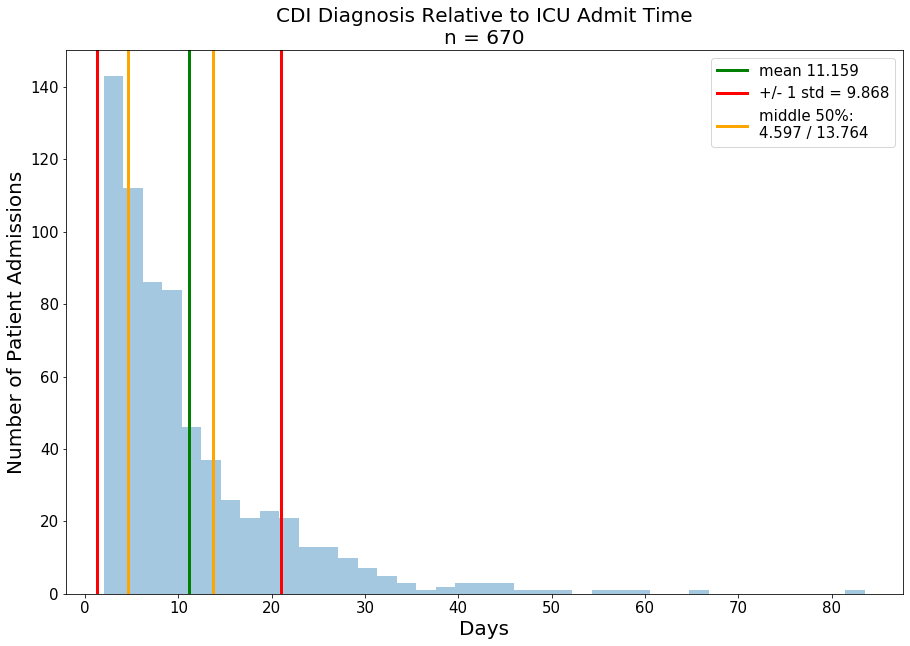

In [47]:
plot_one_hist(series = patient_admits[(patient_admits["cdi_vs_icu_intime"].notnull()) & 
                         (patient_admits["cdi_vs_icu_intime"] >= 2)]["cdi_vs_icu_intime"],
         title = "CDI Diagnosis Relative to ICU Admit Time",
         xlabel = "Days",
         ylabel = "Number of Patient Admissions")

670 ICU visits were associated with CDI diagnosis at least 2 days after start of the ICU admission.

among these patients, average diagnosis came 11 days after admission with 50% of diagnoses between 4.6 and 14 days.

This distribution is strongly right-tailed with normality null hypotheses rejected by both kurtosis and skew tests; p-values 2x10^-26 and 3x10^-56 respectively

## E) Finalize Overall Admissions to Exclude From Analysis

Features already created above and in first notebook not covered by CDI case exclusions:

    1) no ICU stay or hospital discharge < 2 days after ICU admit start (risk assessment will take place at conclusion of 2nd day after ICU admission start)
    2) newborns and babies under 1 (highly likely to be colonized with clostridium difficile without infection and/or have diarrhea due to other causes

In [48]:
print(patient_admits["icu_intime"].dtypes)
print(patient_admits["dischtime"].dtypes)

datetime64[ns]
datetime64[ns]


In [49]:
# Calculate time 2 days after ICU start as cutoff time and then determine if patient is still in hospital
# by calculating difference between cutoff and hospital discharge
cutoff = []
discharge_vs_cutoff = []
for i in patient_admits.index:
    cutoff_time = calc_relative_date(patient_admits.loc[i,"icu_intime"], 2)
    dischtime = patient_admits.loc[i,"dischtime"]
    cutoff.append(cutoff_time)
    if(patient_admits.loc[i,"no_icu_stay"] == 0):
        diff = date_diff(patient_admits.loc[i,"dischtime"], cutoff_time)
        discharge_vs_cutoff.append(diff)
    else:
        discharge_vs_cutoff.append(None)

In [50]:
patient_admits["cutoff_time"] = cutoff
patient_admits["discharge_vs_cutoff"] = discharge_vs_cutoff

In [51]:
# Create column for which non-CDI patients should be excluded
patient_admits["admissions_exclude"] = ((patient_admits["discharge_vs_cutoff"] < 0) |
                                        (patient_admits["age_below_1"] == 1) |
                                        (patient_admits["newborn_admit"] == 1) |
                                        (patient_admits["no_icu_stay"] == 1) |
                                       (patient_admits["discharge_vs_cutoff"] < 0))

In [52]:
# Combined both
patient_admits["overall_exclude"] = ((patient_admits["age_below_1"] == 1) |
                                     (patient_admits["newborn_admit"] == 1) |
                                     (patient_admits["no_icu_stay"] == 1) |
                                     (patient_admits["cdi_vs_icu_intime"] < 2) |
                                     ((patient_admits["cdi_icd9"] == 1) & 
                                      (patient_admits["cdi_lab_dx"] == 0)) |
                                     (patient_admits["discharge_vs_cutoff"] < 0))

In [53]:
# get shape of final dataframe
patient_admits[patient_admits["overall_exclude"] == False].shape

(47000, 48)

In [54]:
# Get counts of CDI cases
patient_admits[patient_admits["overall_exclude"] == False]["cdi_lab_dx"].value_counts()

0    46331
1      669
Name: cdi_lab_dx, dtype: int64

In [55]:
#Calculate CDI cases as % of included ICU stays
669 / 46331

0.014439576093760117

## F) Train Test Split

Done to ensure that all data for a given patient ends up on the same side of the split,
and maintains reasonably similar split of CDI cases

In [56]:
patient_admits.columns

Index(['subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'has_chartevents_data',
       'hosp_los', 'admit_age', 'hospstay_seq', 'first_ethnicity',
       'second_ethnicity', 'admit_icu_los', 'admit_icu_stays', 'cdi_at_admit',
       'no_icu_stay', 'diarr_at_admit', 'newborn_admit', 'age_below_1',
       'cdi_icd9', 'cdi_dx_charttime', 'cdi_lab_dx', 'icu_intime',
       'icu_outtime', 'icu_los', 'icu_stay_seq', 'icustay_id',
       'cdi_vs_icu_intime', 'cutoff_time', 'discharge_vs_cutoff',
       'admissions_exclude', 'overall_exclude'],
      dtype='object')

In [57]:
# Generate unique list of patients
x = pd.DataFrame()
x["unique_patients"] = patient_admits[patient_admits["overall_exclude"] == False]["subject_id"].unique()

# Count number of cdi lab diagnoses
cdi_patients = patient_admits[patient_admits["overall_exclude"] == False].groupby(by="subject_id")["cdi_lab_dx"].sum()

# Merge two series together
xy = pd.merge(x, cdi_patients, how = "outer", left_on = "unique_patients", right_index = True)

# Re-map cdi_lab column for each patient to be binary on having at least 1 CDI Dx over any admission
xy["cdi_lab_dx"] = xy["cdi_lab_dx"].map(lambda x: 1 if x >=1 else 0)


# train test split and stratify on CDI cases
X_train, X_test, y_train, y_test = train_test_split(xy["unique_patients"], 
                                                    xy["cdi_lab_dx"], 
                                                    random_state = 42,
                                                    stratify = xy["cdi_lab_dx"])

In [58]:
#create train and test dataframes based on above splits
icu_admits_train = patient_admits[patient_admits["subject_id"].isin(X_train.to_list())]
icu_admits_test = patient_admits[patient_admits["subject_id"].isin(X_test.to_list())]

In [59]:
# Confirm CDI cases stratified equally
print(icu_admits_train[icu_admits_train["overall_exclude"]==False]["cdi_lab_dx"].value_counts())
print(icu_admits_test[icu_admits_test["overall_exclude"]==False]["cdi_lab_dx"].value_counts())

0    34853
1      501
Name: cdi_lab_dx, dtype: int64
0    11478
1      168
Name: cdi_lab_dx, dtype: int64


In [2]:
# Check CDI rate
501 / (34853 + 501)

0.01417095661028455

In [61]:
# Map cdi lab dx to new column for only included lab diagnoses

icu_admits_train["cdi_dx_include"] = ((icu_admits_train["overall_exclude"] == False) & 
                                      (icu_admits_train["cdi_lab_dx"] == 1)).map(lambda x: 1 if x == True else 0)

icu_admits_test["cdi_dx_include"] = ((icu_admits_test["overall_exclude"] == False) & 
                                      (icu_admits_test["cdi_lab_dx"] == 1)).map(lambda x: 1 if x == True else 0)

C:\Users\fuzzyman27\anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\fuzzyman27\anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Export Data
##### Note that 12,549 patients had admissions that were labeled exclusively with "overall exclude" = True above, and were therefore filtered out here. Given that features will be only based on an individual patient's data, this will not impact further analysis.

In [ ]:
# Export training and test dataframes to csv
icu_admits_train.to_csv("../Data/2 - ICU Admits Train.csv")
icu_admits_test.to_csv("../Data/2 - ICU Admits Test.csv")